<font color="#d3d3d3"><h1><b>Reminder for all students and instructors to use the same version of the project notebooks (beginner or advanced)</b></h1></font>

![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)

This week, we'll be delving right into the projects. You and your group are going to build an AI tool that can help detect distracted drivers on the road. We'll start by understanding our problem, identifying:
* Who are our key stakeholders? (Drivers AND Pedestrians)
* What do they want to solve? (Detecting unsafe behavior while operating a car)
* What kind of data do they have? (Images taken by the car while driving)

Once we have all of this information, we will take a step back and plan our approach to designing our solution.


In this notebook we will be:
1.   Understanding and Visualizing our data
2.   Understanding how to apply ML for Distracted Driver Prediction



In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def label_to_numpy(labels):
  final_labels = np.zeros((len(labels), 4))
  for i in range(len(labels)):
    label = labels[i]
    if label == 'Attentive':
      final_labels[i,:] = np.array([1, 0, 0, 0])
    if label == 'DrinkingCoffee':
      final_labels[i,:] = np.array([0, 1, 0, 0])
    if label == 'UsingMirror':
      final_labels[i,:] = np.array([0, 0, 1, 0])
    if label == 'UsingRadio':
      final_labels[i,:] = np.array([0, 0, 0, 1])
  return final_labels

class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    metadata = metadata[keep_idx]

    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    return metadata

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    # Get dataframes for each class.
    df_coffee_train = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'train')]
    df_coffee_test = metadata[(metadata['class'] == 'DrinkingCoffee') & \
                         (metadata['split'] == 'test')]
    df_mirror_train = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'train')]
    df_mirror_test = metadata[(metadata['class'] == 'UsingMirror') & \
                         (metadata['split'] == 'test')]
    df_attentive_train = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'train')]
    df_attentive_test = metadata[(metadata['class'] == 'Attentive') & \
                         (metadata['split'] == 'test')]
    df_radio_train = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'train')]
    df_radio_test = metadata[(metadata['class'] == 'UsingRadio') & \
                         (metadata['split'] == 'test')]

    # Get number of items in class with lowest number of images.
    num_samples_train = min(df_coffee_train.shape[0], \
                            df_mirror_train.shape[0], \
                            df_attentive_train.shape[0], \
                            df_radio_train.shape[0])
    num_samples_test = min(df_coffee_test.shape[0], \
                            df_mirror_test.shape[0], \
                            df_attentive_test.shape[0], \
                            df_radio_test.shape[0])

    # Resample each of the classes and concatenate the images.
    metadata_train = pd.concat([df_coffee_train.sample(num_samples_train), \
                          df_mirror_train.sample(num_samples_train), \
                          df_attentive_train.sample(num_samples_train), \
                          df_radio_train.sample(num_samples_train) ])
    metadata_test = pd.concat([df_coffee_test.sample(num_samples_test), \
                          df_mirror_test.sample(num_samples_test), \
                          df_attentive_test.sample(num_samples_test), \
                          df_radio_test.sample(num_samples_test) ])

    metadata = pd.concat( [metadata_train, metadata_test] )

    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.prod(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

  def get_field_data(flatten, all_data, metadata, image_shape):
    return get_data_split('field', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, label_str, index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''

    labels = [label_str]
    num_dims   = len(data.shape)
    num_labels = len(labels)
    target_shape = (64,64,3)
    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_acc'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_acc', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_acc', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'acc', data = history, label = 'Training', ax = ax)
    ax.axhline(0.25, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 1)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

### defining project variables
# file variables
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

###
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/metadata.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Driver%20Distraction%20Detection/image_data.npy'


### pre-loading all data of interest
_all_data = np.load(image_data_path)
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_field_data  = lambda flatten = False : pkg.get_field_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels, index = None: helpers.plot_one_image(data = data, label_str = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

metadata.csv.1      100%[===================>] 200.33K  --.-KB/s    in 0.009s  
image_data.npy.1    100%[===================>] 423.61M   193MB/s    in 2.2s    


# Milestone 1. Understanding our data source


## Exercise (Discussion)


<b> What is distracted driving?</b>

Distracted driving is any activity that diverts attention from driving, including talking or texting on your phone, eating and drinking, talking to people in your vehicle, fiddling with the stereo, entertainment or navigation system—anything that takes your attention away from the task of safe driving.

At 55 kilometers per hour, not paying attention to the road for just a brief second or two like driving the length of an entire football field with your eyes closed.

You cannot drive safely unless the task of driving has your full attention. Any non-driving activity you engage in is a potential distraction and increases your risk of crashing.

(Text from https://www.nhtsa.gov/risky-driving/distracted-driving.)

<b>

![](https://s.abcnews.com/images/GMA/190401_gma_benitez2_hpMain_16x9_992.jpg)

  


**What are some unsafe driving behaviors you can think of?**

**What are some features of images that would be relevant to detect for distracted drivers?**


## Exercise (Discussion)


So, what are the big-picture implications of detecting distracted driving (click the image!)

[![How x-rays work](https://i0.wp.com/weeklyvillager.com/wp-content/uploads/2019/01/Distracted-Driving.png?fit=518%2C388&ssl=1)](https://www.youtube.com/watch?v=mKKw-Q1M80o)


**How might a car alert system for distracted driving be useful?**

**Can you find statistics about how many people die or are injured each year from distracted driving? What are some implications of a system that can alert people of their bad practices?**

# Milestone 2. Understand and visualizing our data


## Activity 2a. What data do we have?


### Exercise (Coding)

We have images captured in the car of several drivers in a new camera-enhanced car (batmobiles are becoming a reality!).

The camera in the car saves the images to its filesystem (cars are now computers too!).  

The files are saved in the following format:

```
data_folder/
  |-- TRAIN
      |--Attentive
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
      |--DrinkingCoffee
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
       |--UsingMirror
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
       |--UsingRadio
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
  |-- TEST
      |--Attentive
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
      |--DrinkingCoffee
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
       |--UsingMirror
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
       |--UsingRadio
          |--1.jpeg
          |--2.jpeg            
          |--3.jpeg                        
          |--...
   ...
```

As we see, we have two subfolders in our `data_folder` (stored in the car's hard drive!) that stores images from the camera in the `.jpeg` format. An image in the `Attentive` folder is of a patient who is driving while paying attention to the road. All other images are of distracted drivers (either disracted by drinking a coffee, using the mirror, or using the radio). We have provided functions to you which will read these data for you.

We will use our `get_metadata()` function to look at the classes as well as splits of our data. In general, metadata refers to information used to describe our data. The data are the images themselves while the metadata is information such as which class each image belongs to and whether each image corresponds to a train or test image.

In [ ]:
# get a table with information about ALL of our images
metadata = pkg.get_metadata(metadata_path)

# what does it look like?
metadata.head()

# Uncomment the function below to check the bottom five!
# metadata.tail()

,class,split,index
7405,DrinkingCoffee,train,7405
732,DrinkingCoffee,train,732
6503,DrinkingCoffee,train,6503
6520,DrinkingCoffee,train,6520
420,DrinkingCoffee,train,420


We see a few columns. What are they?
1. `index`: This is a number representing the ID of the image.
2. `class`: This is either UsingRadio, Attentive, DrinkingCoffee, or UsingMirror.
3. `split`: Our collaborators have provided us with two data sets:
  * `training`: we will use this to teach our models
  * `test`: we will measure how well our models do on this set

**Exercise 1**

We want to know how many images we have in total. We can count it with pandas or we can visualize it with seaborn's visualization tools.


For visualizing in graphs, we will want to use the following:

```
sns.countplot(x = 'column_name', data = data_source)
```

As a hint, try to identify:
* What is our column_name for each of our 4 classes?
* What is our data table's name?

<Axes: xlabel='class', ylabel='count'>

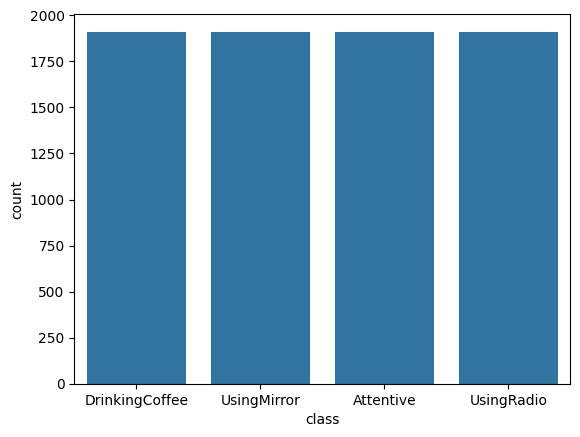

In [ ]:
# grab our seaborn visualization toolbox!
import seaborn as sns

### YOUR CODE HERE
sns.countplot(x = 'class', data = metadata)
### END CODE

**Exercise 2**

We split our data into different 'sets' that each will work differently with our machine learning model.

Think of our AI as a machine learning 'student'.

**Training Set:** Our training set is like a training manual. Our algorithm will read, or 'train', on this over and over again to try and learn its task.

**Test Set:** Our test set is like a test. It is testing our model on problems that it has not seen before.

**We usually have a much larger training manual than our test. Let's see if this is the case with our data!**


Notice that our 'set' designation is found in the metadata. Plot the count of each 'set' in our data below:

*Hint: Think of which column refers to the train/test split*

<Axes: xlabel='split', ylabel='count'>

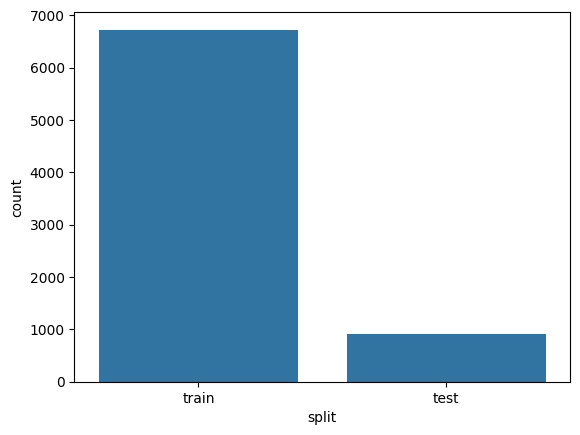

In [ ]:
### YOUR CODE HERE
sns.countplot(x = 'split', data = metadata)
### END CODE

**Exercise 3**

We are also interested in how many of each 'class' (UsingRadio, Attentive, DrinkingCoffee, or UsingMirror) we have in each 'split' (train or test) group by set and count the classes. Try this out with your group! As a hint...
* you might visualize this with seaborn, setting another variable called 'hue' to be either 'class' or 'split'
* you may also try this with the pandas 'groupby' function along with 'count()'. You had done this earlier at the start of the week!

<Axes: xlabel='class', ylabel='count'>

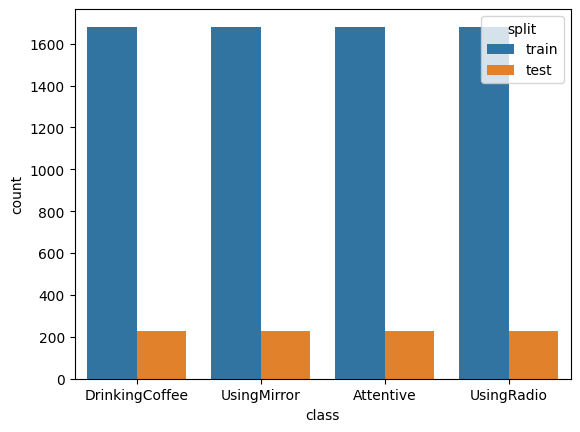

In [ ]:
### YOUR CODE HERE
sns.countplot(x = 'class', data = metadata, hue = 'split')
### END CODE

**Are the classes balanced? Does this help with interpreting our results?**

## Activity 2b. What does our data look like?

We need to understand: what is our data even?? Is it numeric? Is it categorical? Is it a vector or a matrix??

**Question: What do you think the data is?**

Discuss this with your group!



### Exercise 4

We will check what we think the data is against what python tells us it is.

We'll start by loading all of our training set using `get_train_data`.


`get_train_data` is a function that **loads** all of our images and their labels. E.g.

```
X_train, y_train = get_train_data()
```

`X_train` is a numpy array of our images, with size (6724, 64, 64, 3).
`y_train` is a numpy array of our images' labels, with size  (6724,)

We can grab a single `image` from `train_data`.

**Let's try loading a single image!**

In [ ]:
X_train, y_train = get_train_data()
image = X_train[0,:] #this gets the first image in our train_data array
image_label = y_train[0] #this gets the first label in our train_labels array

**What kind of data do we have? What are its dimensions? What is its label?**

In [ ]:
image = image.reshape(64, 64, 3)
print('Our image is stored as %s in Python'%type(image))
print('Our image has dimensions of (%d, %d, %d)'%image.shape)
print('Our image has label %s'%image_label)

Our image is stored as <class 'numpy.ndarray'> in Python
Our image has dimensions of (64, 64, 3)
Our image has label DrinkingCoffee


In [ ]:
#@title What does image shape represent? { display-mode: "form" }

#@markdown What does the bold number (**64**, 64, 3) represent?
Dimension_0  = "image height" #@param ["image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (64, **64**, 3) represent?
Dimension_1  = "image width" #@param ["image width", "image height","number of colors","fill in"]

#@markdown What does the bold number (64, 64, **3**) represent?
Dimension_2  = "number of colors" #@param ["image width", "image height","number of colors","fill in"]

if Dimension_0 == 'image height':
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if Dimension_1 == 'image width':
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")

if Dimension_2 == 'number of colors':
  print("Yes! Dimension_2 stands for 3 colors - (r,g,b).")
else:
  print("Try again for Dimension_2!")


Yes! Dimension_0 is the height of the image.
Yes! Dimension_1 is the width of the image.
Yes! Dimension_2 stands for 3 colors - (r,g,b).


### Exercise 5

Remember our `plot_one_image` function from last week? We'll use that with our data to view our images! Let's see a single image.

`plot_one_image` can take in either one image or many images. To use it with a single image that is 3D, call:

```
plot_one_image(image, labels=[image_label])
```


Label: [['DrinkingCoffee']]


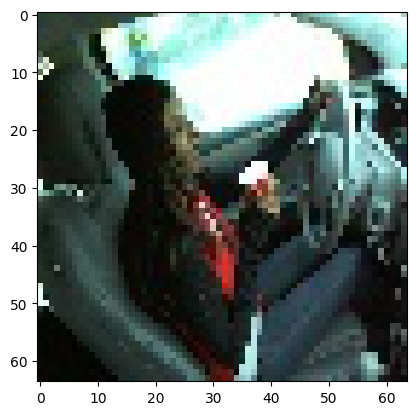

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
plot_one_image(image, labels=[image_label])
### END CODE

### Exercise 6

Let's visualize a few more images from our data!

Recall that we got the image and label in position 0 with:
```
image = X_train[0,:]
image_label = y_train[0]
```
How about the image/label in position *i* ?

Label: [['DrinkingCoffee']]


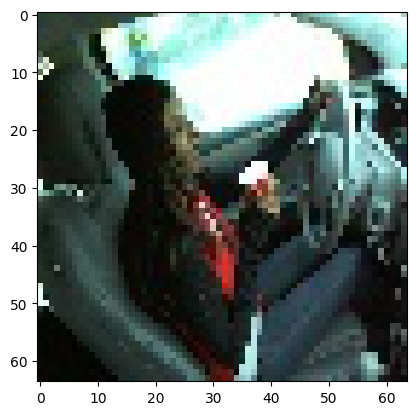

Label: [['DrinkingCoffee']]


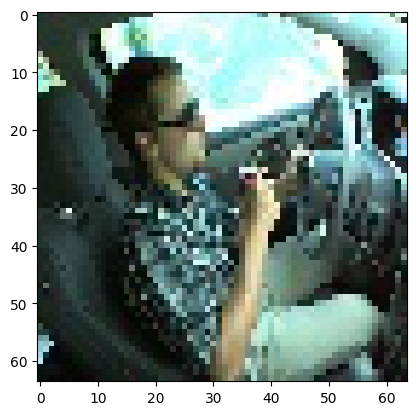

Label: [['DrinkingCoffee']]


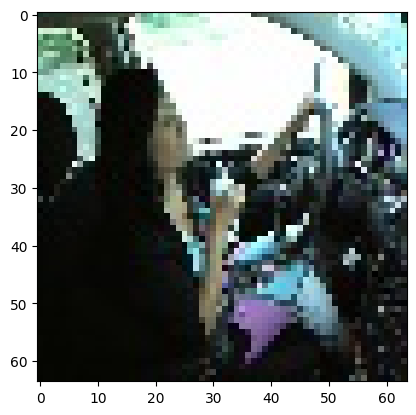

Label: [['DrinkingCoffee']]


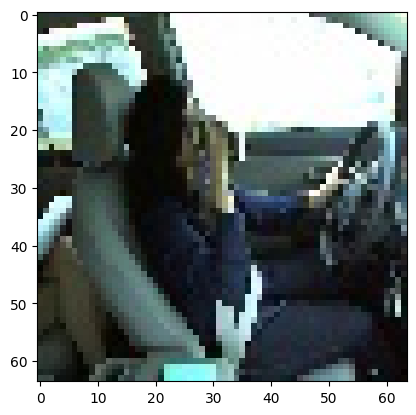

Label: [['DrinkingCoffee']]


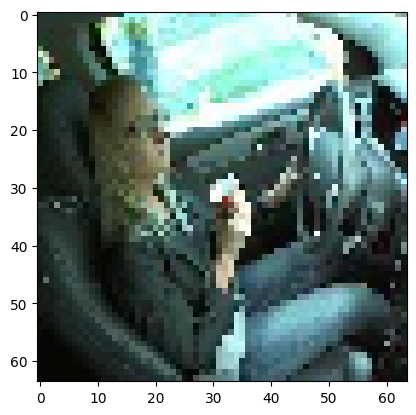

In [ ]:
# use a for loop to visualize more images

### YOUR CODE HERE
for i in range(5):
  image_ID = i
  image = X_train[image_ID,:]
  image_label = y_train[image_ID]
  plot_one_image(image, labels=[image_label])
### END CODE

We want to look at several UsingRadio, Attentive, DrinkingCoffee, and UsingMirror images **separately**. This will give us an idea of what the visual differences are between these 4 types of images.

First, we create separate variables for each class of image:


In [ ]:
radio_X_train = X_train[y_train=='UsingRadio'] #grab all images whose corresponding label is 'UsingRadio'
attentive_X_train = X_train[y_train=='Attentive'] #etc.
coffee_X_train = X_train[y_train=='DrinkingCoffee']
mirror_X_train = X_train[y_train=='UsingMirror']

Now we can modify our previous for loop to visualize a few images from each class separately (don't forget the labels!):

Label: [['UsingRadio']]


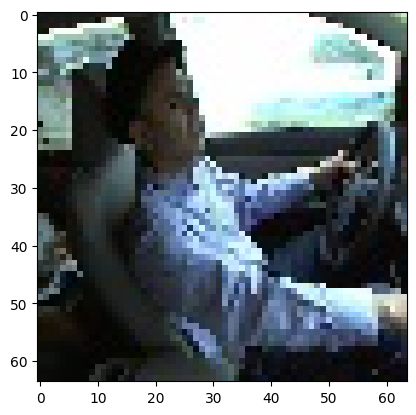

Label: [['UsingRadio']]


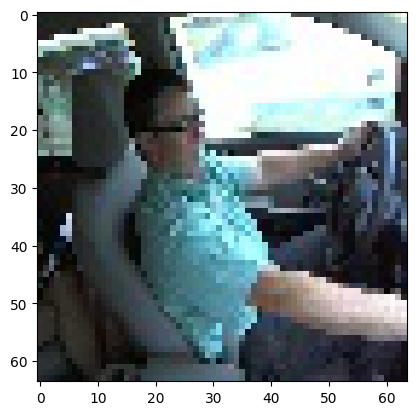

Label: [['UsingRadio']]


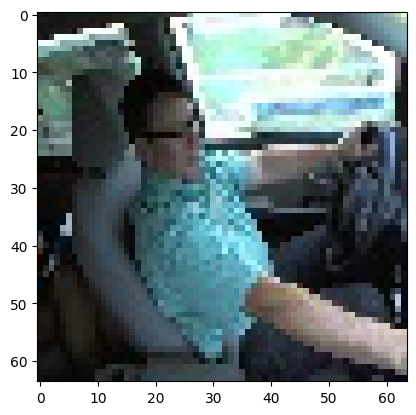

Label: [['UsingRadio']]


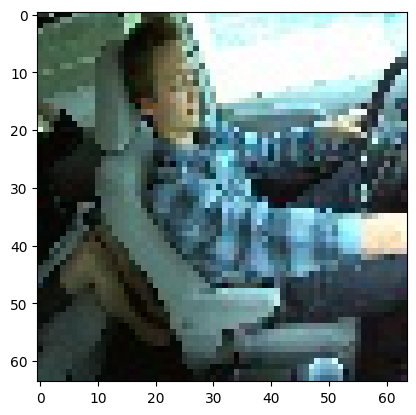

Label: [['UsingRadio']]


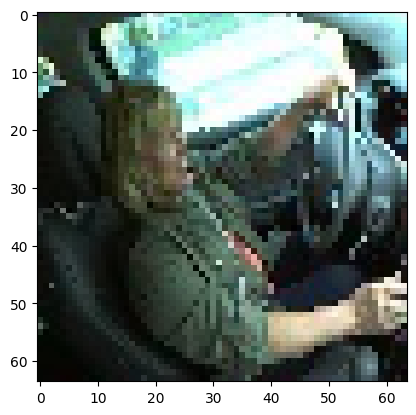

In [ ]:
# use a for loop to visualize UsingRadio images

### YOUR CODE HERE
for i in range(5):
  image_ID = i
  image = radio_X_train[image_ID,:]
  image_label = 'UsingRadio'
  plot_one_image(image, labels=[image_label])
### END CODE

Label: [['Attentive']]


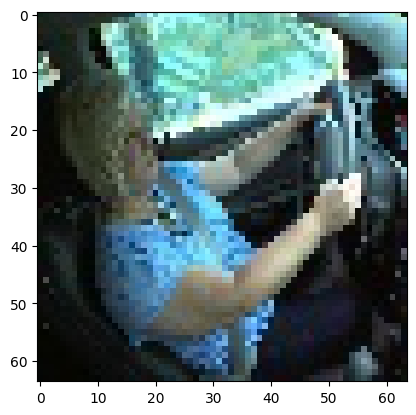

Label: [['Attentive']]


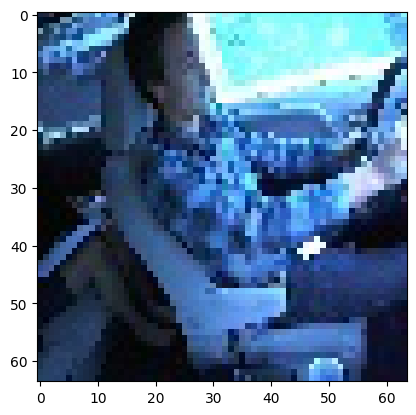

Label: [['Attentive']]


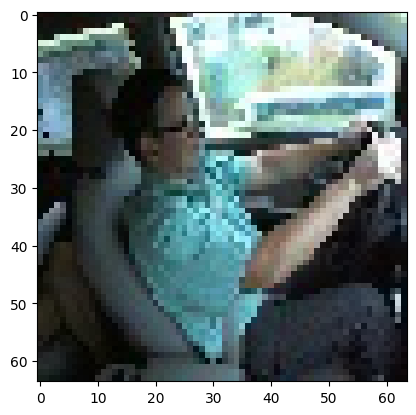

Label: [['Attentive']]


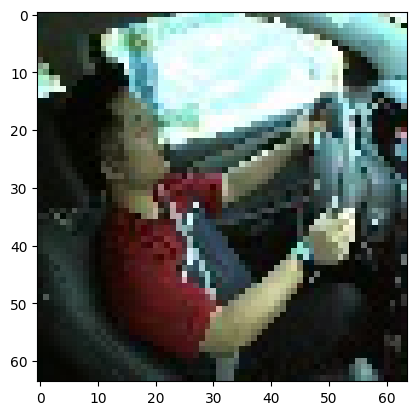

Label: [['Attentive']]


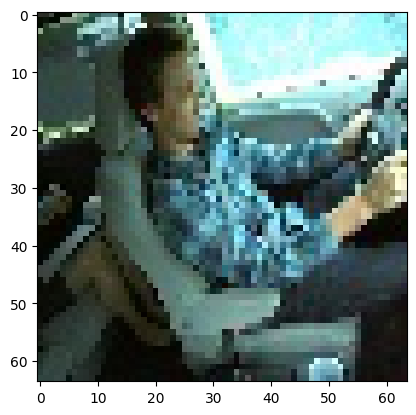

In [ ]:
# use a for loop to visualize DrinkingCoffee images

### YOUR CODE HERE
for i in range(5):
  image_ID = i
  image = attentive_X_train[image_ID,:]
  image_label = 'Attentive'
  plot_one_image(image, labels=[image_label])
### END CODE

Label: [['DrinkingCoffee']]


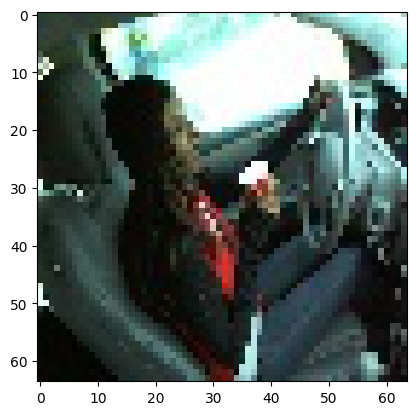

Label: [['DrinkingCoffee']]


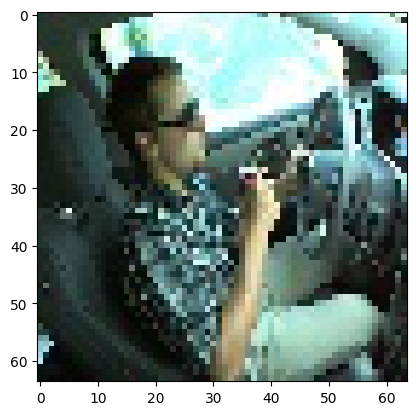

Label: [['DrinkingCoffee']]


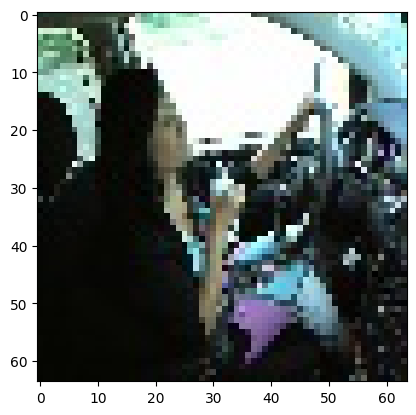

Label: [['DrinkingCoffee']]


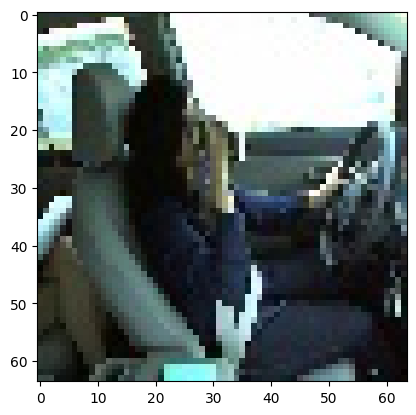

Label: [['DrinkingCoffee']]


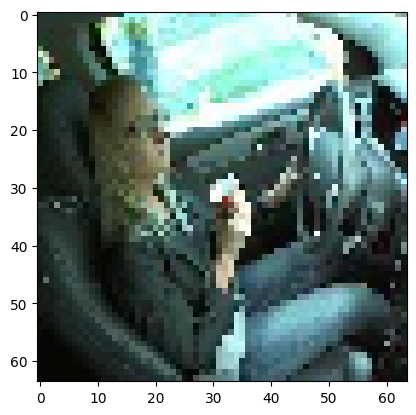

In [ ]:
# use a for loop to visualize UsingMirror images

### YOUR CODE HERE
for i in range(5):
  image_ID = i
  image = coffee_X_train[image_ID,:]
  image_label = 'DrinkingCoffee'
  plot_one_image(image, labels=[image_label])
### END CODE

Label: [['UsingMirror']]


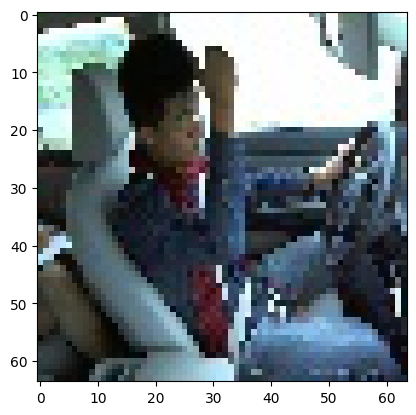

Label: [['UsingMirror']]


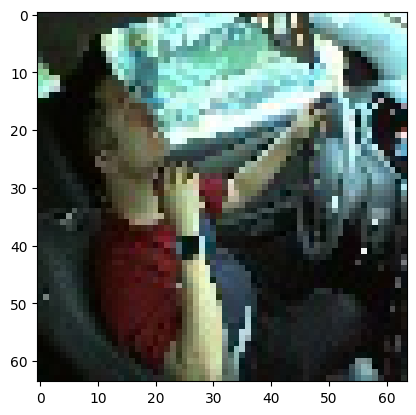

Label: [['UsingMirror']]


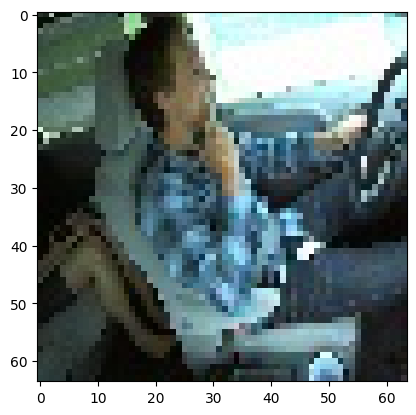

Label: [['UsingMirror']]


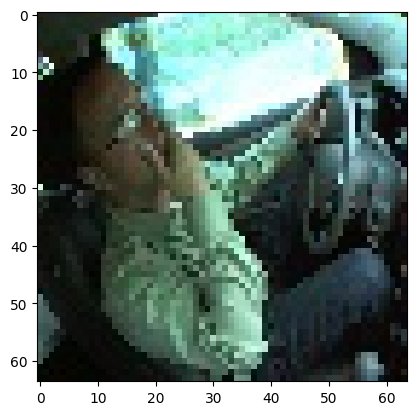

Label: [['UsingMirror']]


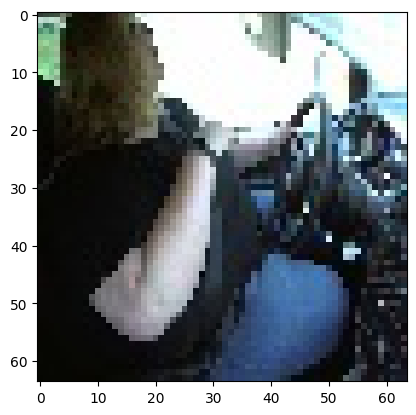

In [ ]:
# use a for loop to visualize Attentive images

### YOUR CODE HERE
for i in range(5):
  image_ID = i
  image = mirror_X_train[image_ID,:]
  image_label = 'UsingMirror'
  plot_one_image(image, labels=[image_label])
### END CODE

### Exercise (Discussion)   



Now that we have our images, let's see if we can tell our images apart! Go see the instructor and gather the relevant handout for this!

## (Optional) Activity 2c. Fun with manipulating images

### Exercise: Tinting (Coding)

Like we saw, an image is a 3D array with (y_location, x_location, rgb). Another way of saying this is that an image is a STACK of color matrices. Let's make this more tangible...

In [ ]:
# first copy our image... Make sure to copy it! Otherwise, we overwrite our original image.
image = image.reshape(64, 64, 3)
new_image = image.copy()

Now, we will change two of the color dimensions in order to add tinting to the image. Do this with the new_image variable create above and visualize it!!

*Hint:*
Recall that the third dimension of our image refers to color. When accessing a dimension of an array, `:` means "take all values along that dimension".

So, `new_image[:, :, i]` is the `i`th color value for all the pixels (entire width and height). What are valid values for `i`?




In [ ]:
### YOUR CODE HERE

### END CODE

Feel free to change the color dimensions above to see the different ways you can manipulate the color of the images!

### Exercise (Coding)

You've probably used an image crop before, where you segment part of an image out, like below:

![](https://ppom.nmediahosting.com/wp-content/uploads/2013/06/cropping.jpg)

The first step to doing this is identifying a rectangle in the image. Let's try to color -just- a rectangle in our `new_image`.

In [ ]:
rect_image = image.copy()

Recall that you can access a pixel at the location (5, 5) in the image like...
```
image[5][5]
```

In [ ]:
image[5,5]

To get the red color of this, you can do

In [ ]:
image[5,5,0]

And you can change all of the color of one pixel with...
```
image[5,5] = [1, 1, 1]
```
or a single color (here, red) of that pixel:
```
image[5,5,0] = 0.5
```

### Drawing a rectangle to view how to add privacy to the dataset.


With this in mind, can you write a for loop to draw a red rectangle on our image and specifically over the face of the person in the car? This will enable us to maintain privacy in our dataset while still preserving the useful features for making predictions (e.g., the position of the hands).



In [ ]:
# Making a copy of the image!
new_image = np.copy(image)

# Define the bounds of the rectangle (remember how many rows and columns we have total)
# start_row =
# stop_row =
# start_col =
# stop_col =

# Our red color. Should the values be ints or floats? Try 'em out!
# new_color =

# Use slicing to draw a rectangle
new_image[start_row:stop_row, start_col:stop_col] = new_color

plot_one_image(new_image)


# Milestone 3. Applying Machine Learning to Distracted Driver Prediction



## Activity 3a. Defining our machine learning problem


Before we build our model, we have to identify what kind of problem it will solve and what data it's going to use.

### Exercise (Discussion)

What WILL our model look like? Remember, in machine learning, we always identify **inputs** and **outputs**. Our goal is to predict **outputs** from **inputs** with either **classification** or **regression**.

In **classification**, our output is a category (like dogs or cats).

In **regression**, our output is a value (like 0, 0.1, 0.3, 100, ...).

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs?
inputs = "images" #@param ["attentive vs. distracted", "images", "image edges", "probability of attentive vs. distracted", "FillMe"]

#@markdown What are our outputs?
outputs = "UsingRadio, Attentive, DrinkingCoffee, or UsingMirror" #@param ["UsingRadio, Attentive, DrinkingCoffee, or UsingMirror", "images", "image edges", "Probability of being each class", "FillMe"]

#@markdown What kind of problem will our AI model solve?
problem_type  = "classification" #@param ["classification", "regression","FillMe"]


if inputs == "images":
  print("Yes, our inputs are our images!")
else:
  print('Not quite our inputs.')

if outputs == "UsingRadio, Attentive, DrinkingCoffee, or UsingMirror":
  print("Yes, our outputs are the class labels!")
else:
  print('Not quite our outputs.')

if problem_type == "classification":
  print("We are trying to predict labels, therefore this is classification!")
else:
  print('Not quite our problem!')

Yes, our inputs are our images!
Yes, our outputs are the class labels!
We are trying to predict labels, therefore this is classification!


## Activity 3b. Building and evaluating models

### Exercise (Coding)   


Now that you've built several machine learning models, build classifiers on our dataset and see how best you can do! The data is provided for you below.

Sklearn takes in 'flat' data: that is, data that looks like a table, and is just samples by features. As we learned, our images are stored as a (64, 64, 3) array. To use our images with sklearn, we have to first flatten them, like we see below:

In [ ]:
(X_train, y_train) = get_train_data(flatten=True)

We've tried a few models in sklearn since last week. Below, we define them with some sample parameters:
* `knn = KNeighborsClassifier(n_neighbors = 5)`
* `dt = DecisionTreeClassifier(max_depth = 2)`



Test your models with `accuracy_score` on the test_data, which can be grabbed through `get_test_data`!

For reference on these functions, check out your notebooks from the first half of the course.

**Try to build the best model that you can! Experiment with some parameters.** Today, because we are not yet using neural nets (that'll be the focus of the next few days!), our target accuracy is only 50%! (Remember we are predicting 1 of 4 classes, so random chance is 25%). We also won't evaluate overfitting today. As we progress through the project, we will evaluate both accuracy and whether we are overfitting.

In [ ]:
### Get our data and flatten it
(X_train, y_train) = get_train_data(flatten=True)
(X_test, y_test) = get_test_data(flatten=True)

### YOUR CODE BELOW
### For each model you try: define the model (with your parameters), fit the model with the train data and labels,
### predict on the test data, then print the accuracy_score
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)
print(accuracy_1*100)
### FEEL FREE TO CREATE ADDITIONAL CELLS!
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_2 = accuracy_score(y_test, y_pred)
print(accuracy_2*100)

50.54347826086957
35.21739130434783


# Finished!


![](http://static1.squarespace.com/static/56ccc8724c2f8548059fbcfe/58f6daea15d5dbcc64ef63aa/5cae2d770d92977242838baa/1557942174418/SW-DistractedDriving-Clean-1.jpg?format=1500w)